### Keras
 - Machine Learning 라이브러리 Theano와 TesnorFlow를 Wrapping한 라이브러리 (https://deeplearning4j.org/kr/compare-dl4j-torch7-pylearn)
  - Theano는 Numpy와 같은 다차원 배열을 다루는 라이브러리
  - Tensorflow는 Theano를 대체하기 위해 나온 라이브러리
 - 케라스는 파이썬으로 구현된 쉽고 간결한 딥러닝 라이브러리입니다. 딥러닝 비전문가라도 각자 분야에서 손쉽게 딥러닝 모델을 개발하고 활용할 수 있도록 케라스는 직관적인 API를 제공하고 있습니다. 내부적으로는 텐서플로우(TensorFlow), 티아노(Theano), CNTK 등의 딥러닝 전용 엔진이 구동되지만 케라스 사용자는 복잡한 내부 엔진을 알 필요는 없습니다. 직관적인 API로 쉽게 다층퍼셉트론 모델, 컨볼루션 신경망 모델, 순환 신경망 모델 또는 이를 조합한 모델은 물론 다중 입력 또는 다중 출력 등 다양한 구성을 할 수 있습니다. (https://tykimos.github.io/2017/01/27/Keras_Talk/)

#### Keras로 비만도 판정하기

In [4]:
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.callbacks import EarlyStopping
import pandas as pd, numpy as np
import os

Using TensorFlow backend.


In [5]:
os.getcwd()

'/Users/tomato/projects/Play_with_Data_2nd/5. 딥러닝'

In [6]:
# BMI 데이터를 읽어 들이고 정규화하기 --- (※1)
csv = pd.read_csv("./ch5/bmi.csv")

In [7]:
print(csv.shape)
csv.head()

(20000, 3)


,height,weight,label
0,142,62,fat
1,142,73,fat
2,177,61,normal
3,187,48,thin
4,153,60,fat


In [10]:
# 몸무게와 키 데이터 - 정규화: 데이터의 범위를 일치시키거나 분포를 유사하게 만들어 주기
csv["weight"] /= 100
csv["height"] /= 200
X = csv[["weight", "height"]].as_matrix() # --- (※1a)
print(X)


[[ 0.0062    0.00355 ]
 [ 0.0073    0.00355 ]
 [ 0.0061    0.004425]
 ..., 
 [ 0.0037    0.004825]
 [ 0.0051    0.004875]
 [ 0.0067    0.004075]]


- Pandas의 DataFrame형을 Keras에서는 Numpy의 ndarray로 변형해서 써야하기 떄문에 as.Matrix를 사용하였다.

In [11]:
# 레이블 -문자열을 One Hot Encoding을 사용해서 변환해준다.
bclass = {"thin":[1,0,0], "normal":[0,1,0], "fat":[0,0,1]}
y = np.empty((20000,3))
for i, v in enumerate(csv["label"]):
    y[i] = bclass[v]
print(y)

[[ 0.  0.  1.]
 [ 0.  0.  1.]
 [ 0.  1.  0.]
 ..., 
 [ 1.  0.  0.]
 [ 1.  0.  0.]
 [ 0.  1.  0.]]


In [12]:
# 훈련 전용 데이터와 테스트 전용 데이터로 나누기 --- (※2)
X_train, y_train = X[1:15001], y[1:15001]
X_test,  y_test  = X[15001:20001], y[15001:20001] 

시퀀스 모델을 생성한 뒤 필요한 레이어를 추가하여 구성합니다.
좀 더 복잡한 모델이 필요할 때는 케라스 함수 API를 사용합니다

In [14]:
from IPython.display import Image
from IPython.core.display import HTML 
Image(url= "http://tykimos.github.io/warehouse/2017-1-27_MLP_Layer_Talk_neuron.png")

- x0, x1, x2 : 입력되는 뉴런의 축삭돌기로부터 전달되는 신호의 양
- w0, w1, w2 : 시냅스의 강도, 즉 입력되는 뉴런의 영향력을 나타냅니다.
- w0x0 + w1x1 + w2*x2 : 입력되는 신호의 양과 해당 신호의 시냅스 강도가 곱해진 값의 합계
- f : 최종 합계가 다른 뉴런에게 전달되는 신호의 양을 결정짓는 규칙, 이를 활성화 함수라고 부릅니다.

In [15]:
X = np.array([1.0,0.5]) # 입력이 2개 (x1, x2)
W1 = np.array([[0.1,0.3,0.5],[0.2,0.4,0.6]]) # 입력에 대응하는 weights 
B1 = np.array([0.1,0.2,0.3]) # bias

print(X.shape) # 1x2
print(W1.shape) # 2x3
print(B1.shape)# 1x3


#출처: http://3months.tistory.com/65 [Deep Play]

(2,)
(2, 3)
(3,)


https://tensorflowkorea.gitbooks.io/tensorflow-kr/content/g3doc/resources/dims_types.html
https://www.tensorflow.org/programmers_guide/tensors
- Rank	Shape	Dimension number	Example
- 0	[]	0-D	A 0-D tensor. A scalar.
- 1	[D0]	1-D	A 1-D tensor with shape [5].
- 2	[D0, D1]	2-D	A 2-D tensor with shape [3, 4].
- 3	[D0, D1, D2]	3-D	A 3-D tensor with shape [1, 4, 3].
- n	[D0, D1, ... Dn-1]	n-D	A tensor with shape [D0, D1, ... Dn-1].
    

In [17]:
# 모델 구조 정의하기 --- (※3)
model = Sequential()
model.add(Dense(512, input_shape=(2,))) 
# Just your regular densely-connected NN layer.
# now the model will take as input arrays of shape (*, 2)
# and output arrays of shape (*, 512)
model.add(Activation('relu'))
model.add(Dropout(0.1)) #드롭 아웃은 오버피팅(over-fit)을 막기 위한 방법으로 뉴럴 네트워크가 학습중일때, 랜덤하게 뉴런을 꺼서 학습을 방해함으로써, 학습이 학습용 데이타에 치우치는 현상을 막아준다. 
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.1))
model.add(Dense(3))
model.add(Activation('softmax'))

학습하기 전에 학습에 대한 설정을 수행합니다.
손실 함수 및 최적화 방법을 정의합니다.
 - loss : 현재 가중치 세트를 평가하는 데 사용한 손실 함수 입니다. 다중 클래스 문제이므로 ‘categorical_crossentropy’으로 지정합니다.
 - optimizer : 최적의 가중치를 검색하는 데 사용되는 최적화 알고리즘으로 효율적인 경사 하강법 알고리즘 중 하나인 rmsprop 사용
  - SGD: Stochastic Gradient Descent, 이 방법에서는 loss function을 계산할 때 전체 데이터(batch) 대신 일부 조그마한 데이터의 모음(mini-batch)에 대해서만 loss function을 계산한다
 - metrics : 평가 척도를 나타내며 분류 문제에서는 일반적으로 ‘accuracy’으로 지정합니다.

In [18]:
# 모델 구축하기 --- (※4)
model.compile(
    loss='categorical_crossentropy',
    optimizer="rmsprop",
    metrics=['accuracy'])


'''
x : 입력 데이터
y : 라벨 값
batch_size : 몇 개의 샘플로 가중치를 갱신할 것인지 지정
epochs : 학습 반복 횟수
'''
- Batch Size=100 : 전체 Train Set에 대해서 100개 단위로 나눈 후에, 100개기반으로 Fitting후 가중치를 변경
- epochs =20: 같은 Train Set에 대한 Fitting을 20번씩 반복해서 가중치를 수정해나감
- validation_split: 10%의 train set에 대해서는 남겨두었다가 매 epoch마다 해당 train_set을 기반으로 loss 및 기타 수치에 대해 evaluation
- callback: 더 이상 개선의 여지가 없을 때 학습을 종료,  여기서는 fit 함수에서 EarlyStopping이라는 콜백함수가 학습 과정 중에 매번 호출됩니다.

In [20]:
# 데이터 훈련하기 --- (※5)
hist = model.fit(
    X_train, y_train,
    batch_size=100,
    epochs=20,
    validation_split=0.1,
    callbacks=[EarlyStopping(monitor='val_loss', patience=2)],
    verbose=1)

print(hist.history['loss'])
print(hist.history['acc'])
print(hist.history['val_loss'])
print(hist.history['val_acc'])


Train on 13500 samples, validate on 1500 samples
Epoch 1/20
13500/13500 [==============================] - 2s 161us/step - loss: 0.8310 - acc: 0.5934 - val_loss: 0.7233 - val_acc: 0.6793
Epoch 2/20
13500/13500 [==============================] - 2s 163us/step - loss: 0.8205 - acc: 0.5936 - val_loss: 0.8559 - val_acc: 0.5413
Epoch 3/20
13500/13500 [==============================] - 2s 159us/step - loss: 0.8061 - acc: 0.6072 - val_loss: 0.8422 - val_acc: 0.5873
[0.83104994032118051, 0.82048611287717466, 0.80613664786020911]
[0.59340740574730766, 0.59362962930290786, 0.60718518407256517]
[0.72327702840169272, 0.85588003396987911, 0.842198657989502]
[0.67933333714803057, 0.54133333365122482, 0.58733333746592209]


- train_loss(노란색) : 훈련 손실값이며 x축은 에포크 수, 좌측 y축은 손실값을 나타냅니다.
- val_loss(빨간색) : 검증 손실값이며 x축은 에포크 수, 좌측 y축은 손실값을 나타냅니다.
- train_acc(파란색) : 훈련 정확도이며 x축은 에포크 수, 우측 y축은 정확도를 나타냅니다.
- val_acc(녹색) : 검증 정확도이며 x축은 에포크 수, 우측 y축은 정확도를 나타냅니다.

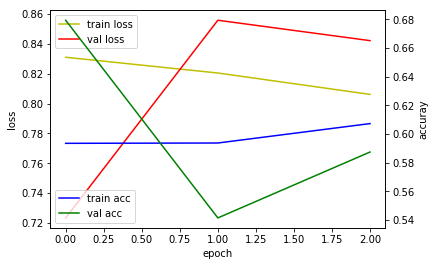

In [21]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, loss_ax = plt.subplots()

acc_ax = loss_ax.twinx()

loss_ax.plot(hist.history['loss'], 'y', label='train loss')
loss_ax.plot(hist.history['val_loss'], 'r', label='val loss')

acc_ax.plot(hist.history['acc'], 'b', label='train acc')
acc_ax.plot(hist.history['val_acc'], 'g', label='val acc')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuray')

loss_ax.legend(loc='upper left')
acc_ax.legend(loc='lower left')

plt.show()

준비된 시험셋으로 학습한 모델을 평가합니다.
케라스에서는 evaluate() 함수를 사용합니다.

In [27]:
# 테스트 데이터로 평가하기 --- (※6)
score = model.evaluate(X_test, y_test)
print('loss=', score[0])
print('accuracy=', score[1])

4999/4999 [==============================] - 1s 101us/step
loss= 0.831344424045
accuracy= 0.594918983821


#### TensorFlow로 비만도 판정해보기

In [28]:
import pandas as pd
import numpy as np
import tensorflow as tf

In [29]:
# 키, 몸무게, 레이블이 적힌 CSV 파일 읽어 들이기 --- (※1)
csv = pd.read_csv("./ch5/bmi.csv")

In [30]:
print(csv.shape)
csv.head(5)

(20000, 3)


,height,weight,label
0,142,62,fat
1,142,73,fat
2,177,61,normal
3,187,48,thin
4,153,60,fat


In [31]:
# 데이터 정규화 --- (※2)
csv["height"] = csv["height"] / 200
csv["weight"] = csv["weight"] / 100

csv.head(5)

,height,weight,label
0,0.710,0.62,fat
1,0.710,0.73,fat
2,0.885,0.61,normal
3,0.935,0.48,thin
4,0.765,0.60,fat


In [32]:
# 레이블을 배열로 변환하기 --- (※3)
# - thin=(1,0,0) / normal=(0,1,0) / fat=(0,0,1)
bclass = {"thin": [1,0,0], "normal": [0,1,0], "fat": [0,0,1]}
csv["label_pat"] = csv["label"].apply(lambda x : np.array(bclass[x]))

In [33]:
# 테스트를 위한 데이터 분류 --- (※4)
test_csv = csv[15000:20000]
test_pat = test_csv[["weight","height"]]
test_ans = list(test_csv["label_pat"])

In [38]:
# 데이터 플로우 그래프 구출하기 --- (※5)
# 플레이스홀더 선언하기
x  = tf.placeholder(tf.float32, [None, 2]) # 키와 몸무게 데이터 넣기
y_ = tf.placeholder(tf.float32, [None, 3]) # 정답 레이블 넣기

In [39]:
# 변수 선언하기 --- (※6)
W = tf.Variable(tf.zeros([2, 3])); # 가중치
b = tf.Variable(tf.zeros([3])); # 바이어스

In [40]:
# 소프트맥스 회귀 정의하기 --- (※7)
y = tf.nn.softmax(tf.matmul(x, W) + b)
# Softmax(소프트맥스)는 입력받은 값을 출력으로 0~1사이의 값으로 모두 정규화하며 출력 값들의 총합은 항상 1이 되는 특성을 가진 함수

In [41]:
from IPython.display import Image
from IPython.core.display import HTML 
Image(url= "https://mblogthumb-phinf.pstatic.net/MjAxNzA2MDVfNDMg/MDAxNDk2NTkwNTY2Njcx.-soSHRQ2urRoHGkkQk-OmHJ1HJIvpS3YuO1SXeecBAQg.LVPXD-PxQ5o8mK9uPMkqvp18vwjyKUypfRfYlqTv_B8g.JPEG.wideeyed/softmax_f.jpg?type=w2")

 - 입력값의 대소 순서가 출력값의 대소 순서와 같다는 것을 알 수 있다.
 - 결국 가장 큰 값은 이미 소프트맥스 이전에 가장 큰 값이였다. 
 - 따라서 추론(운영)단계에서 연산속도를 빠르기하기 위해 생략하기도 한다.

In [42]:
# 모델 훈련하기 --- (※8)
cross_entropy = -tf.reduce_sum(y_ * tf.log(y))
optimizer = tf.train.GradientDescentOptimizer(0.01)
train = optimizer.minimize(cross_entropy)

In [43]:
# 정답률 구하기
predict = tf.equal(tf.argmax(y, 1), tf.argmax(y_,1))
accuracy = tf.reduce_mean(tf.cast(predict, tf.float32))

In [44]:
# 세션 시작하기
sess = tf.Session()
sess.run(tf.global_variables_initializer()) # 변수 초기화하기

In [45]:
dir(tf)

['AUTO_REUSE',
 'AggregationMethod',
 'Assert',
 'AttrValue',
 'COMPILER_VERSION',
 'CXX11_ABI_FLAG',
 'ConditionalAccumulator',
 'ConditionalAccumulatorBase',
 'ConfigProto',
 'DType',
 'DeviceSpec',
 'Dimension',
 'Event',
 'FIFOQueue',
 'FixedLenFeature',
 'FixedLenSequenceFeature',
 'FixedLengthRecordReader',
 'GIT_VERSION',
 'GPUOptions',
 'GRAPH_DEF_VERSION',
 'GRAPH_DEF_VERSION_MIN_CONSUMER',
 'GRAPH_DEF_VERSION_MIN_PRODUCER',
 'Graph',
 'GraphDef',
 'GraphKeys',
 'GraphOptions',
 'HistogramProto',
 'IdentityReader',
 'IndexedSlices',
 'InteractiveSession',
 'LMDBReader',
 'LogMessage',
 'MONOLITHIC_BUILD',
 'MetaGraphDef',
 'NameAttrList',
 'NoGradient',
 'NodeDef',
 'NotDifferentiable',
 'OpError',
 'Operation',
 'OptimizerOptions',
 'PaddingFIFOQueue',
 'Print',
 'PriorityQueue',
 'QUANTIZED_DTYPES',
 'QueueBase',
 'RandomShuffleQueue',
 'ReaderBase',
 'RegisterGradient',
 'RunMetadata',
 'RunOptions',
 'Session',
 'SessionLog',
 'SparseConditionalAccumulator',
 'SparseFeatur

In [50]:
# 학습시키기
for step in range(3500):
    i = (step * 100) % 14000
    rows = csv[1 + i : 1 + i + 100]
    x_pat = rows[["weight","height"]]
    y_ans = list(rows["label_pat"])
    fd = {x: x_pat, y_: y_ans}
    sess.run(train, feed_dict=fd)
    if step % 500 == 0:
        cre = sess.run(cross_entropy, feed_dict=fd)
        acc = sess.run(accuracy, feed_dict={x: test_pat, y_: test_ans})
        print("step=", step, "cre=", cre, "acc=", acc)

step= 0 cre= 23.2966 acc= 0.9806
step= 500 cre= 25.259 acc= 0.9774
step= 1000 cre= 22.0772 acc= 0.9792
step= 1500 cre= 24.093 acc= 0.9766
step= 2000 cre= 20.4672 acc= 0.9784
step= 2500 cre= 21.7008 acc= 0.9804
step= 3000 cre= 16.6176 acc= 0.977


In [51]:
# 최종적인 정답률 구하기
acc = sess.run(accuracy, feed_dict={x: test_pat, y_: test_ans})
print("정답률 =", acc)

정답률 = 0.9772
